In [9]:
from qutip import *
import numpy as np
import random as rnd
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['axes.linewidth'] = 1.5

plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8

In [5]:
X = sigmax()
Y = sigmay()
Z = sigmaz()
I = qeye(2)

def Hxxx(N, edges, h=1):
    global X,Y,Z,I
    matrices = [I for i in range(N)]
    sumsigmaz = 0
    sumsigmaxx = 0
    sumsigmayy = 0
    sumsigmazz = 0
    if type(h) is int:
        h *= np.ones(N)
#     if type(J) is int:
#         J *= np.ones(len(edges))        
    for i in range(N):
        matrices[i] = Z
        sumsigmaz += h[i]*tensor(matrices)
        matrices[i] = I    
    for i in range(len(edges)):
        matrices[edges[i][0]] = X
        matrices[edges[i][1]] = X
        sumsigmaxx += edges[i][2]*tensor(matrices)
#         matrices[edges[i][0]] = I
#         matrices[edges[i][1]] = I
        matrices[edges[i][0]] = Y
        matrices[edges[i][1]] = Y
        sumsigmayy += edges[i][2]*tensor(matrices)
#         matrices[edges[i][0]] = I
#         matrices[edges[i][1]] = I
        matrices[edges[i][0]] = Z
        matrices[edges[i][1]] = Z
        sumsigmazz += edges[i][2]*tensor(matrices)
        matrices[edges[i][0]] = I
        matrices[edges[i][1]] = I  
    H = sumsigmaxx+sumsigmazz+sumsigmayy+ sumsigmaz
    return H

def excstate(N):
    up = tensor([basis(2,0) for n in range(N)])
    state = up*up.dag()
    return state

def most_excited_state(H0):
    excited_state = H0.eigenstates()[1][-1]
    state = excited_state*excited_state.dag()
    return state

def calc_erg(H_vals, H_vecs, rho_vals, rho_vecs):
    erg = 0
    for i in range(H_vals.shape[0]):
        for j in range(H_vals.shape[0]):
            delta = 0
            if i==j:
                delta = 1
            erg += (rho_vals[i]*H_vals[j]) * ((np.abs((rho_vecs[i].dag()*H_vecs[j])[0,0]))**2 - delta)
    return erg
    
def charge(H0, Htot, ancilla, target, tracekeep, times):
    
    fidel = []
    ergotropy = []

    HsystEigEn, HsysEigVec = H0.eigenstates(sparse=False, sort='low', eigvals=0, tol=0, maxiter=100000)
    _, gsket = H0.groundstate()
    rhoGs = gsket*gsket.dag()
    rhoGsVals, rhoGsVecs = rhoGs.eigenstates(sparse=False, sort='high', eigvals=0, tol=0, maxiter=100000)
    ergotropy.append(calc_erg(HsystEigEn, HsysEigVec, rhoGsVals, rhoGsVecs))
    fidel.append(fidelity(target,rhoGs))

    t = np.linspace(0,1,100)
    Rin = tensor(ancilla, rhoGs)
    
    for r in range(times):
        Rt = mesolve(Htot,Rin,t)
        Rtstates = Rt.states[-1].unit()
        Rsyst_red = ptrace(Rtstates,tracekeep).unit()
        RsystEigEn, RsystEigVec = Rsyst_red.eigenstates(sparse=False, sort='high', eigvals=0, tol=0, maxiter=100000)
        ergotropy.append(calc_erg(HsystEigEn, HsysEigVec, RsystEigEn, RsystEigVec))
        fidel.append(fidelity(target,Rsyst_red))
        Rin=tensor(ancilla,Rsyst_red)
    return ergotropy, fidel, Rsyst_red

In [4]:
h = 1 
N0 = 4
times, realizations = 100 , 5
t = np.linspace(0,1,100)

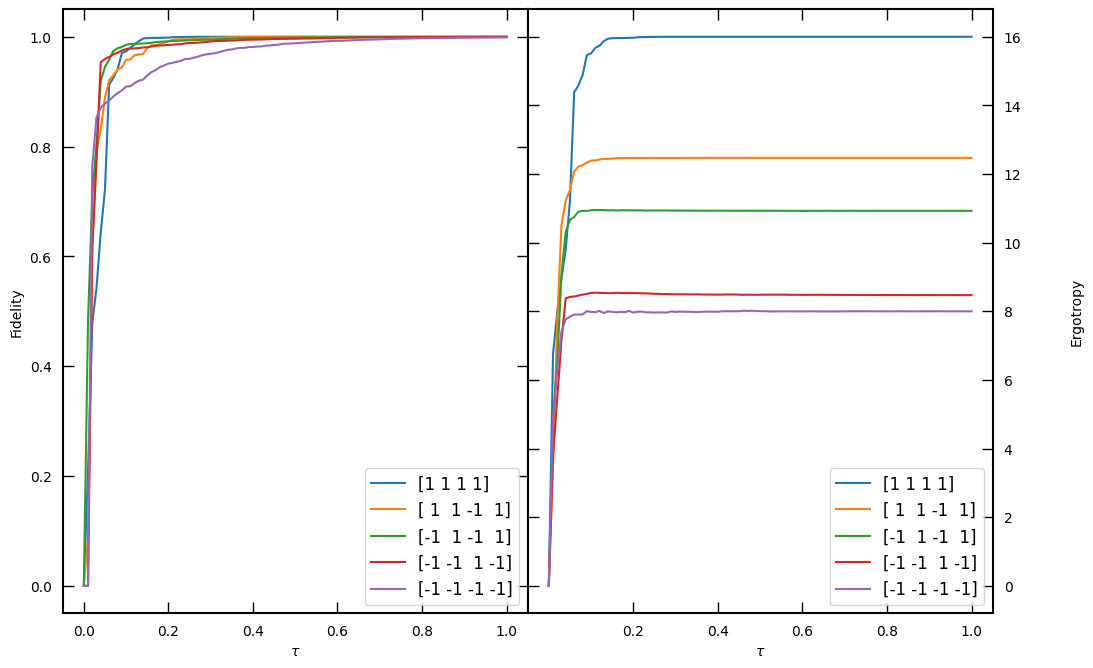

In [8]:
fid = np.zeros(shape=(realizations, times+1))
ergotropy = np.zeros(shape=(realizations, times+1))
states = []

Jall=np.array([[1,1,1,1], [1,1,-1,1], [ -1,1,-1,1],[ -1,-1,1,-1], [-1,-1,-1,-1]])
g = [1,1,1,1]
p = [1,1,1,1]

for r in range(realizations):
    J = Jall[r]

    edges0 = [[0,1,J[0]],[1,2,J[1]],[2,3,J[2]],[3,0,J[3]]]
    edges1 = [[0,1,g[0]],[1,2,J[0]],[2,3,J[1]],[3,4,J[2]],[4,1,J[3]]]
    edges20= [[0,2,g[0]],[1,3,g[1]],[2,3,J[0]],[3,4,J[1]],[4,5,J[2]],[5,2,J[3]]]
    edges21= [[0,1,p[0]],[0,2,g[0]],[1,3,g[1]],[2,3,J[0]],[3,4,J[1]],[4,5,J[2]],[5,2,J[3]]]
    edges30= [[0,3,g[0]],[1,4,g[1]],[2,5,g[2]],[3,4,J[0]],[4,5,J[1]],[5,6,J[2]],[6,3,J[3]]]
    edges33= [[0,1,p[0]],[1,2,p[1]],[2,0,p[2]],[0,3,g[0]],[1,4,g[1]],[2,5,g[2]],[3,4,J[0]],[4,5,J[1]],[5,6,J[2]],[6,3,J[3]]]
    edges40= [[0,4,g[0]],[1,5,g[1]],[2,6,g[2]],[3,7,g[3]],[4,5,J[0]],[5,6,J[1]],[6,7,J[2]],[7,4,J[3]]]
    edges44= [[0,1,p[0]],[1,2,p[1]],[2,3,p[2]],[3,1,p[3]],[0,4,g[0]],[1,5,g[1]],[2,6,g[2]],[3,7,g[3]],[4,5,J[0]],[5,6,J[1]],[6,7,J[2]],[7,4,J[3]]]

    edges = [[1,edges1],[2,edges20],[2,edges21],[3,edges30],[3,edges33],[4,edges40],[4,edges44]]

    H0 = Hxxx(N0, edges0, h=1)
    HsystEigEn, HsysEigVec = H0.eigenstates(sparse=False, sort='low', eigvals=0, tol=0, maxiter=100000)
    target = excstate(N0)
    
    _, gsket = H0.groundstate()
    rhoGs = gsket*gsket.dag()
    rhoGsVals, rhoGsVecs = rhoGs.eigenstates(sparse=False, sort='high', eigvals=0, tol=0, maxiter=100000)
    ergotropy[r,0] = calc_erg(HsystEigEn, HsysEigVec, rhoGsVals, rhoGsVecs)
    fid[r,0] = fidelity(target,rhoGs)


    Rsyst_red = rhoGs
    t = np.linspace(0,1,100)
    for i in range(times):    

        edge = rnd.choice(edges)
        N = N0+edge[0]
        edges1= edge[1]

        Htot = Hxxx(N, edges1, h=1)
        ancilla = excstate(N-N0)
        tracekeep = np.arange((N-N0),N,1)

        Rin=tensor(ancilla,Rsyst_red)
        Rt = mesolve(Htot,Rin,t)
        Rtstates = Rt.states[-1].unit()
        Rsyst_red = ptrace(Rtstates,tracekeep).unit()

        RsystEigVal, RsystEigVec = Rsyst_red.eigenstates(sparse=False, sort='high', eigvals=0, tol=0, maxiter=100000)
        ergotropy[r,i+1] = calc_erg(HsystEigEn, HsysEigVec, RsystEigVal, RsystEigVec)
        fid[r,i+1] = fidelity(target,Rsyst_red)

fig, axs = plt.subplots(1,2,figsize=(12,8), dpi=100)
plt.subplots_adjust(wspace=0,hspace=0)

t=np.linspace(0,1,101)
for r in range(realizations):
    axs[0].plot(t, fid[r], label = str(Jall[r]))
    axs[1].plot(t, ergotropy[r], label= str(Jall[r]))
    axs[0].set_ylabel(r'Fidelity')
    axs[1].set_ylabel(r'Ergotropy',labelpad=-400)

axs[1].set_xticks(axs[1].get_xticks()[2:-1])
axs[1].tick_params(labelleft=False,labelright=True)

for idx in [0,1]:
    axs[idx].legend(fontsize=12)
    axs[idx].set_xlabel('$\\tau$')
    
    for e in ['x', 'y']:
        axs[idx].tick_params(axis=e,which='major',size=8,width=1,direction='in',top='on',right='on')

In [11]:
import sys
sys.path.append('../')
np.save('./data/randomHeisenberg.npy', (fid, ergotropy))